# What are the most used skills for the 3 most popular data roles?

#### Step:
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final result

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Filter Data for the Indonesia

In [2]:
df_INA = df[df['job_country'] == 'Indonesia']

## Explode Skill

In [3]:
df_skills = df_INA.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
643,Data Scientist,python
643,Data Scientist,r
643,Data Scientist,aws
643,Data Scientist,gcp
643,Data Scientist,azure
...,...,...
785312,Machine Learning Engineer,scikit-learn
785312,Machine Learning Engineer,tensorflow
785312,Machine Learning Engineer,pytorch
785567,Data Analyst Intern,r


## Count Skills per JobTitle

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as skill_count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
718,sql,Data Engineer,596
555,python,Data Engineer,455
556,python,Data Scientist,342
719,sql,Data Scientist,319
689,spark,Data Engineer,235
...,...,...,...
822,vue.js,Machine Learning Engineer,1
841,yarn,Software Engineer,1
842,zoom,Data Analyst,1
7,airflow,Senior Data Scientist,1


## Create 3 list of top 3 roles

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plotting the skill counts

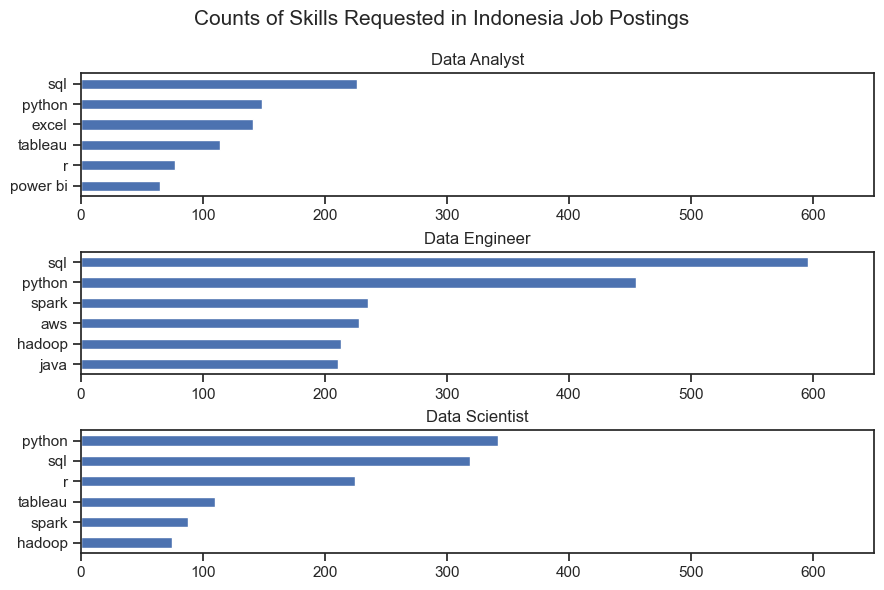

In [36]:
fig, ax = plt.subplots(len(job_titles), 1, figsize=(9, 6))

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(6)
    df_plot.plot(
        kind='barh', 
        x='job_skills', 
        y='skill_count', 
        ax=ax[i],
        title=job_title,
    )
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 650)

fig.suptitle('Counts of Skills Requested in Indonesia Job Postings', fontsize=15)
fig.tight_layout(h_pad=.5) 

plt.show()

## Convert Counts to Percentages

In [14]:
# Use the original dataframe to get the count of job titles
df_job_title_count = df_INA['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,1040
1,Data Scientist,645
2,Data Analyst,461
3,Software Engineer,288
4,Senior Data Engineer,117
5,Business Analyst,115
6,Senior Data Scientist,109
7,Cloud Engineer,101
8,Machine Learning Engineer,67
9,Senior Data Analyst,50


In [16]:
# Merge the two dataframes
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left') 

# Calculate the percentage of each skill
df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100 

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,596,1040,57.307692
1,python,Data Engineer,455,1040,43.750000
2,python,Data Scientist,342,645,53.023256
3,sql,Data Scientist,319,645,49.457364
4,spark,Data Engineer,235,1040,22.596154
...,...,...,...,...,...
840,vue.js,Machine Learning Engineer,1,67,1.492537
841,yarn,Software Engineer,1,288,0.347222
842,zoom,Data Analyst,1,461,0.216920
843,airflow,Senior Data Scientist,1,109,0.917431


## Plotting percentage count

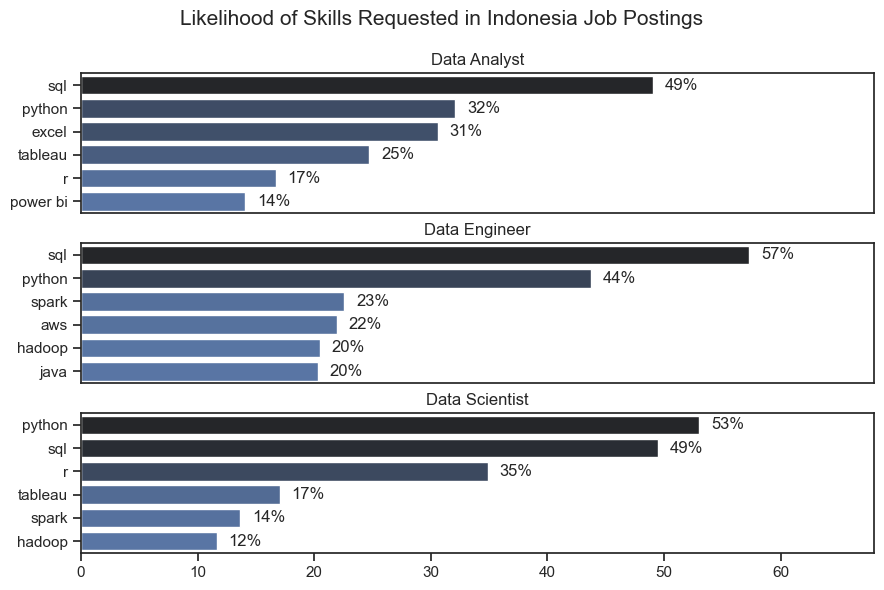

In [30]:
fig, ax = plt.subplots(len(job_titles), 1, figsize=(9, 6))

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(6)
    sns.barplot(
        data=df_plot, 
        x='skill_percent', 
        y='job_skills', 
        ax=ax[i], 
        hue='skill_count', 
        palette='dark:b_r'
    )
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 68)
    
    # remove the x-axis tick labels except for the last plot
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in Indonesia Job Postings', fontsize=15)
fig.tight_layout(h_pad=.6)
plt.show()